In [137]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, \
make_scorer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

In [138]:
def fail_recall(y_true,y_pred):
    """
    uses sklearn.metrics.recall_score() to return the recall score of
    non functioning wells.
    Takes single column array or dataframe of true labels
    and one of predictions 
    returns recall score of class 0.
    """
    
    return recall_score(y_true,y_pred,average=None)[0]

recaller = make_scorer(fail_recall)

## Drop the irrelevant columns, 

In [80]:
df = pd.read_csv('content/regs_with_activity_stats.csv')
df.drop(columns = ['id_student','code_module','code_presentation','module_presentation_length',
                  'total_days_studied'], inplace = True)
df.loc[df['final_result'] == 'Withdrawn', 'final_result'] = 'Fail'
df.loc[df['final_result'] == 'Distinction', 'final_result'] = 'Pass'
df.head()

,gender,highest_education,age_band,num_of_prev_attempts,disability,final_result,date_registration,avg_daily_activities,mean_clicks_per_day,pct_days_studied
0,M,HE Qualification,55<=,0,N,Pass,-159.0,4.695652,25.521739,0.255556
1,F,HE Qualification,35-55,0,N,Pass,-53.0,6.388889,22.805556,0.400000
2,F,A Level or Equivalent,35-55,0,N,Pass,-52.0,5.803922,19.450980,0.566667
3,F,Lower Than A Level,0-35,0,N,Pass,-176.0,5.400000,19.542857,0.388889
4,M,A Level or Equivalent,35-55,0,N,Pass,-110.0,5.206897,18.275862,0.644444


## Preprocessing

In [143]:
X = df.drop(columns = ['final_result'])
y = df['final_result']
binarizer = LabelEncoder()
y = binarizer.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=111, test_size=0.2)

In [144]:
y[:4]

array([1, 1, 1, 1])

In [145]:
binarizer.classes_

array(['Fail', 'Pass'], dtype=object)

In [146]:
categoricals = X.select_dtypes(include = 'object').columns
numericals = X.select_dtypes(include = 'number').columns
transformers = [('ohe', OneHotEncoder(sparse = False, drop= 'first'), categoricals),
                 ('scaler', StandardScaler(), numericals)]
col_transformer = ColumnTransformer(transformers = transformers)

cv = KFold(n_splits = 5, shuffle = True, random_state = 111)

# FSM

In [147]:
LRpipeline = Pipeline(steps = [('processor', col_transformer),
                             ('model', LogisticRegression(class_weight='balanced'))])

LRscores = cross_val_score(LRpipeline, X_train, y_train,
                        scoring = recaller,
                        cv = cv,
                        n_jobs = -1)
scores

array([0.66139161, 0.6729465 , 0.66063803, 0.66415473, 0.66239638])

In [148]:
recall_score(y_test,y_pred, average=None)

array([0.69214876, 0.64353831])

In [149]:
confusion_matrix(y_test,y_pred, normalize = 'true')

array([[0.69214876, 0.30785124],
       [0.35646169, 0.64353831]])

# Other Models

### Logistic Regression

In [153]:
params = [{'model__solver':['liblinear'], 'model__tol':[1e-4,1e-5],
           'model__class_weight':['balanced',None],'model__max_iter':[500,1000]},
          {'model__solver':['sag','saga','newton-cg'], 'model__tol':[1e-4,1e-5],
           'model__class_weight':['balanced',None],'model__max_iter':[500,1000],
          'model__penalty':['none', 'l2']}]

LRpipeline = Pipeline(steps = [('processor', col_transformer),
                             ('model', LogisticRegression(class_weight='balanced'))])

LRclf = GridSearchCV(LRpipeline, params, scoring = recaller)

LRclf.fit(X_train,y_train.reshape(-1,))

print('best params', LRclf.best_params_)
print('mean_test_scores', LRclf.cv_results_['mean_test_score'])

C:\Users\caell\new_Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\caell\new_Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\caell\new_Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\caell\new_Anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


best params {'model__class_weight': 'balanced', 'model__max_iter': 500, 'model__solver': 'liblinear', 'model__tol': 0.0001}
mean_test_scores [0.7065627  0.7065627  0.7065627  0.7065627  0.50136452 0.50136452
 0.50136452 0.50136452 0.70630279 0.70630279 0.70630279 0.70630279
 0.70630279 0.70630279 0.7065627  0.7065627  0.7065627  0.7065627
 0.7065627  0.7065627  0.70630279 0.70630279 0.70630279 0.70630279
 0.70630279 0.70630279 0.7065627  0.7065627  0.7065627  0.7065627
 0.7065627  0.7065627  0.50149448 0.50149448 0.50149448 0.50149448
 0.50149448 0.50149448 0.50149448 0.50149448 0.50149448 0.50149448
 0.50149448 0.50149448 0.50149448 0.50149448 0.50149448 0.50149448
 0.50149448 0.50149448 0.50149448 0.50149448 0.50149448 0.50149448
 0.50149448 0.50149448]


              precision    recall  f1-score   support

           0       0.55      0.69      0.61      1936
           1       0.77      0.64      0.70      3041

    accuracy                           0.66      4977
   macro avg       0.66      0.67      0.66      4977
weighted avg       0.68      0.66      0.67      4977



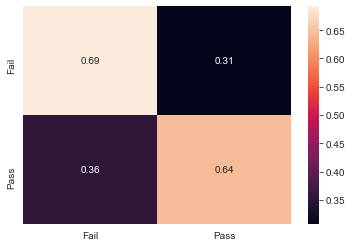

In [156]:
y_pred = LRclf.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred, normalize = 'true'),
           xticklabels = binarizer.classes_,
           yticklabels = binarizer.classes_,
           annot = True)

### Gaussian Naive Bayes

In [157]:
GNBpipeline = Pipeline(steps = [('processor', col_transformer),
                               ('model', GaussianNB())])
GNBscores = cross_val_score(GNBpipeline, X_train, y_train,
                        scoring = recaller,
                        cv = cv,
                        n_jobs = -1)
GNBscores

array([0.60025221, 0.64190094, 0.57151899, 0.60496311, 0.64572539])

### Decision Tree

In [92]:
DTpipeline = Pipeline(steps = [('processor', col_transformer),
                               ('model', DecisionTreeClassifier())])
DTscores = cross_val_score(DTpipeline, X_train, y_train,
                        scoring = 'accuracy',
                        cv = cv,
                        n_jobs = -1)
DTscores

array([0.60838985, 0.61190656, 0.60437076, 0.60638031, 0.59708616])

In [ ]:
params = {'model__criterion':['gini','entropy'],'model__splitter':['best','random'],
         'model__max_depth':[5,10,20]}

DTclf

### Random Forest

In [93]:
RFpipeline = Pipeline(steps = [('processor', col_transformer),
                               ('model', RandomForestClassifier())])
RFscores = cross_val_score(RFpipeline, X_train, y_train,
                        scoring = 'accuracy',
                        cv = cv,
                        n_jobs = -1)
RFscores

array([0.67545843, 0.68952524, 0.67621201, 0.68952524, 0.67018337])

accuracy 0.6734980912196102


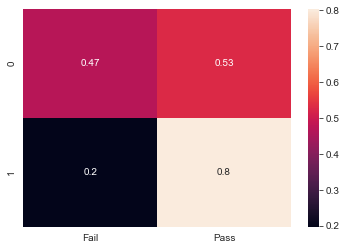

In [100]:
RFpipeline.fit(X_train,y_train)
y_pred = RFpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = RFpipeline.classes_)

accuracy 0.6065903154510749


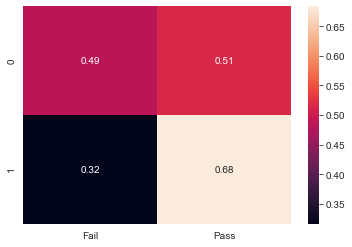

In [101]:
DTpipeline.fit(X_train,y_train)
y_pred = DTpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = DTpipeline.classes_)

accuracy 0.6576250753465943


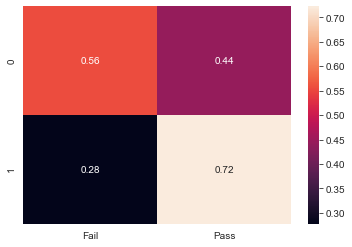

In [102]:
GNBpipeline.fit(X_train,y_train)
y_pred = GNBpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = GNBpipeline.classes_)

accuracy 0.6624472573839663


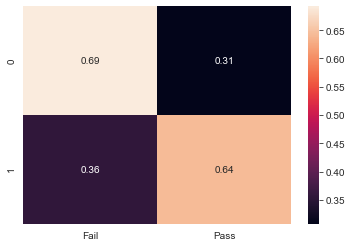

In [103]:
LRpipeline.fit(X_train,y_train)
y_pred = LRpipeline.predict(X_test)
print('accuracy', accuracy_score(y_test,y_pred))
confusion = confusion_matrix(y_test,y_pred, normalize = 'true')
sns.heatmap(confusion, annot = True,
           xticklabels = LRpipeline.classes_)

# GridSearch

In [62]:
pipeline.coef_

AttributeError: 'Pipeline' object has no attribute 'coef_'

In [67]:
LR = pipeline.named_steps['model']
CT = pipeline.named_steps['processing']

In [69]:

pd.DataFrame(LR.coef_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.250445,-0.223371,0.16229,0.208445,-0.364026,-0.549366,0.569731,-0.06644,0.052298,0.041217,0.19017,-0.163096,0.02076,-0.204827,0.020716,-0.149852,0.102676,0.867659


In [70]:
X_train_3

,id_student,gender,highest_education,age_band,num_of_prev_attempts,disability,date_registration,avg_daily_activities,mean_clicks_per_day,pct_days_studied
3875,389249,F,A Level or Equivalent,0-35,0,N,-36.0,3.280000,9.000000,0.277778
19845,277577,F,A Level or Equivalent,35-55,2,N,-17.0,7.459770,28.919540,0.966667
9174,686558,M,A Level or Equivalent,0-35,0,N,-53.0,5.000000,27.900000,0.222222
15586,634433,M,A Level or Equivalent,0-35,0,N,-17.0,4.312500,12.625000,0.355556
5834,654585,F,HE Qualification,0-35,0,N,-122.0,4.379310,11.862069,0.322222
...,...,...,...,...,...,...,...,...,...,...
7443,627386,M,A Level or Equivalent,0-35,0,N,-25.0,3.000000,12.187500,0.177778
4182,594061,F,A Level or Equivalent,0-35,0,N,-59.0,7.906250,32.515625,0.711111
4820,2334930,F,A Level or Equivalent,0-35,0,N,-130.0,3.000000,5.636364,0.244444
10196,552921,F,A Level or Equivalent,0-35,0,N,-22.0,5.415094,10.226415,0.588889


Let's try a GridSearch